
# Multi-agent Reinforcement Learning With WarpDrive

* **Author:** Sunil Srinivasa (sunil.srinivasa@salesforce.com), Tian Lan (tian.lan@salesforce.com), Huan Wang (huan.wang@salesforce.com) and Stephan Zheng(stephan.zheng@salesforce.com)
* **License:** BSD 3-Clause "New" or "Revised" License
* **Generated:** 2022-05-18T01:28:32.002384

This notebook introduces multi-agent reinforcement learning (MARL) with WarpDrive (Lan et al. https://arxiv.org/abs/2108.13976). WarpDrive is a flexible, lightweight, and easy-to-use open-source framework that implements end-to-end deep MARL on GPUs. WarpDrive enables orders-of-magnitude speedups compared to CPU-GPU implementations, using the parallelization capability of GPUs and several design choices to minimize communication overhead. WarpDrive also prioritizes user-friendliness - it has utility functions to easily build MARL environments in CUDA and quality-of-life tools to run end-to-end MARL using just a few lines of code, and is compatible with PyTorch.
WarpDrive includes the following resources. code - https://github.com/salesforce/warp-drive documentation - http://opensource.salesforce.com/warp-drive/, and white paper - https://arxiv.org/abs/2108.13976.

---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/warp-drive.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [ ]:
! pip install --quiet "ffmpeg-python" "rl-warp-drive>=1.6.5" "setuptools==59.5.0" "ipython[notebook]" "torch>=1.8" "torch==1.10.*" "torchvision==0.11.*" "torchtext==0.11.*" "torchmetrics>=0.7" "pytorch-lightning>=1.4"

**⚠️ PLEASE NOTE:**
This notebook runs on a GPU runtime. If running on Colab, choose Runtime > Change runtime type from the menu, then select `GPU` in the 'Hardware accelerator' dropdown menu.

## Introduction

This tutorial provides a demonstration of a multi-agent Reinforcement Learning (RL) training loop with [WarpDrive](https://github.com/salesforce/warp-drive). WarpDrive is a flexible, lightweight, and easy-to-use RL framework that implements end-to-end deep multi-agent RL on a GPU (Graphics Processing Unit). Using the extreme parallelization capability of GPUs, it enables [orders-of-magnitude faster RL](https://arxiv.org/abs/2108.13976) compared to common implementations that blend CPU simulations and GPU models. WarpDrive is extremely efficient as it runs simulations across multiple agents and multiple environment replicas all in parallel and completely eliminates the back-and-forth data copying between the CPU and the GPU during every step. As such, WarpDrive
- Can simulate 1000s of agents in each environment and thousands of environments in parallel, harnessing the extreme parallelism capability of GPUs.
- Eliminates communication between CPU and GPU, and also within the GPU, as read and write operations occur in-place.
- Is fully compatible with Pytorch, a highly flexible and very fast deep learning framework.
- Implements parallel action sampling on CUDA C, which is ~3x faster than using Pytorch’s sampling methods.
- Allows for large-scale distributed training on multiple GPUs.

Below is an overview of WarpDrive’s layout of computational and data structures on a single GPU.
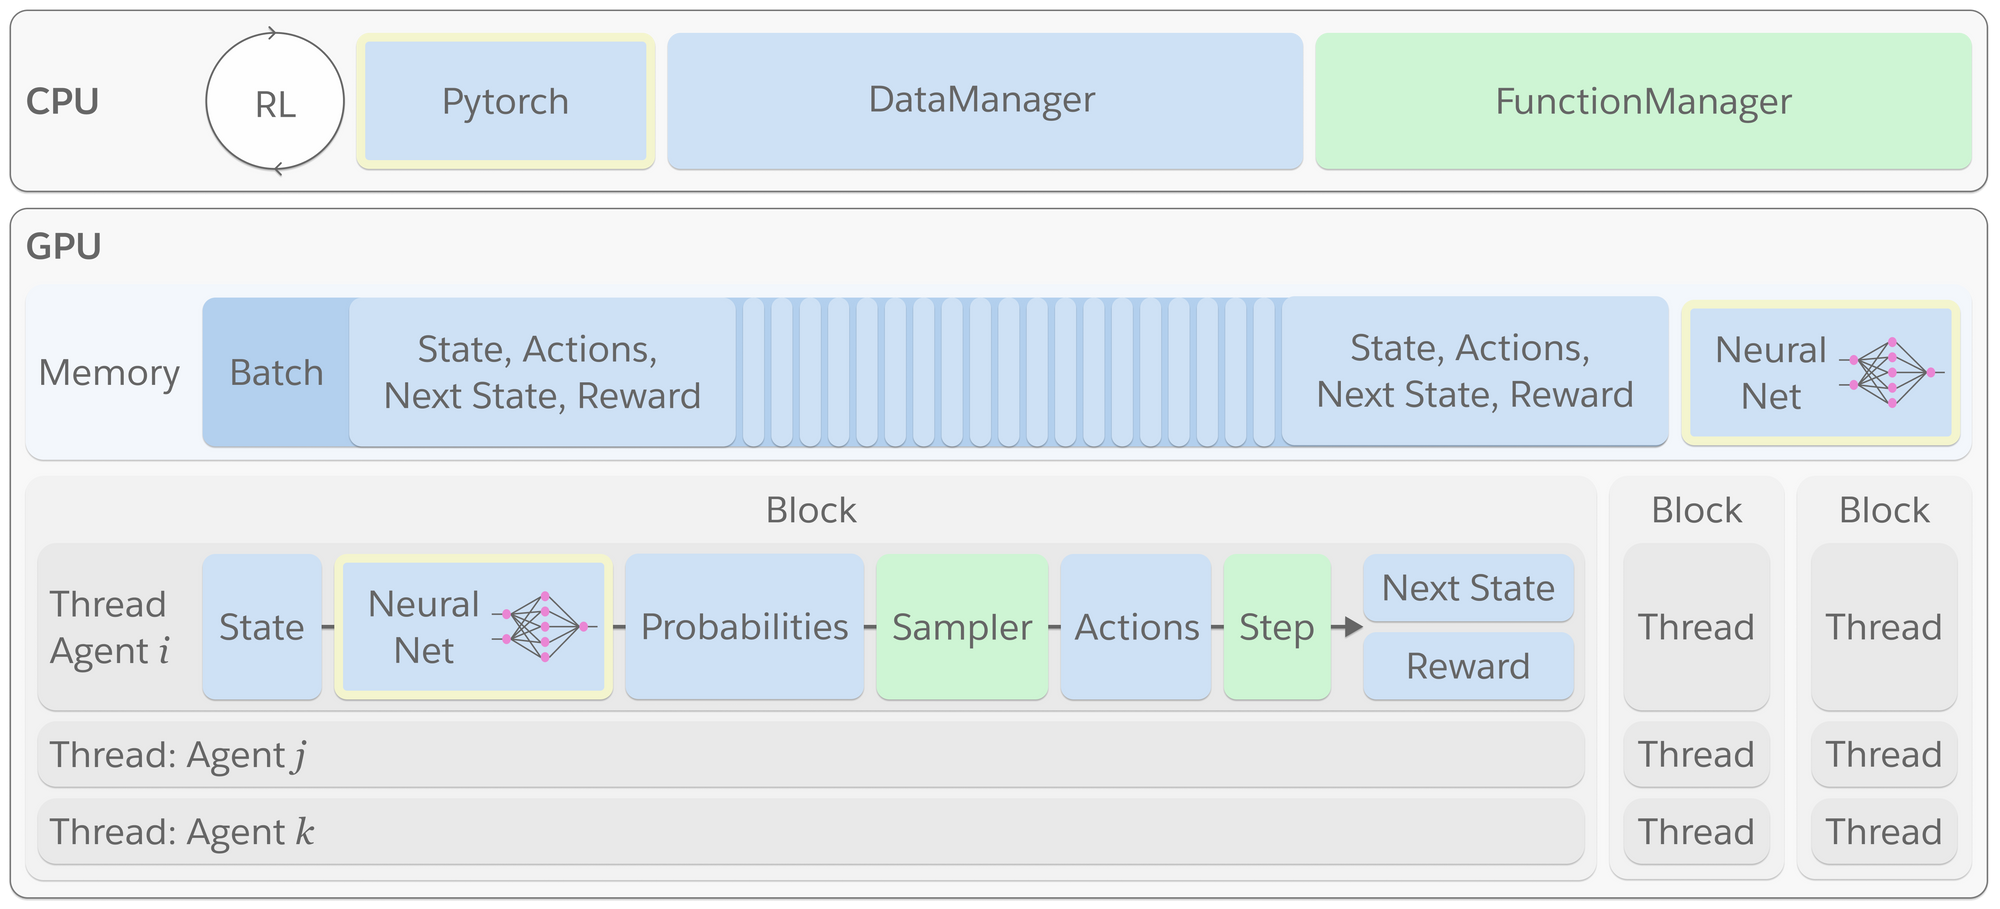
Computations are organized into blocks, with multiple threads in each block. Each block runs a simulation environment and each thread
simulates an agent in an environment. Blocks can access the shared GPU memory that stores simulation data and neural network policy models. A DataManager and FunctionManager enable defining multi-agent RL GPU-workflows with Python APIs. For more details, please read out white [paper](https://arxiv.org/abs/2108.13976).

The Warpdrive framework comprises several utility functions that help easily implement any (OpenAI-)*gym-style* RL environment, and furthermore, provides quality-of-life tools to train it end-to-end using just a few lines of code. You may familiarize yourself with WarpDrive with the help of these [tutorials](https://github.com/salesforce/warp-drive/tree/master/tutorials).

We invite everyone to **contribute to WarpDrive**, including adding new multi-agent environments, proposing new features and reporting issues on our open source [repository](https://github.com/salesforce/warp-drive).

We have integrated WarpDrive with the [Pytorch Lightning](https://www.pytorchlightning.ai/) framework, which greatly reduces the trainer boilerplate code, and improves training modularity and flexibility. It abstracts away most of the engineering pieces of code, so users can focus on research and building models, and iterate on experiments really fast. Pytorch Lightning also provides support for easily running the model on any hardware, performing distributed training, model checkpointing, performance profiling, logging and visualization.

Below, we demonstrate how to use WarpDrive and PytorchLightning together to train a game of [Tag](https://github.com/salesforce/warp-drive/blob/master/example_envs/tag_continuous/tag_continuous.py) where multiple *tagger* agents are trying to run after and tag multiple other *runner* agents. Here's a sample depiction of the game of Tag with $100$ runners and $5$ taggers.
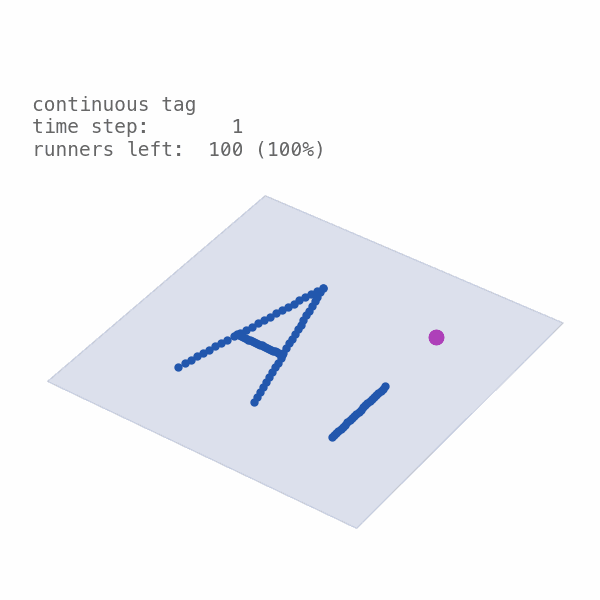

## Dependencies

In [ ]:
import logging

import torch
from example_envs.tag_continuous.tag_continuous import TagContinuous
from pytorch_lightning import Trainer
from warp_drive.env_wrapper import EnvWrapper
from warp_drive.training.pytorch_lightning import CUDACallback, PerfStatsCallback, WarpDriveModule

# Uncomment below for enabling animation visualizations.
# from example_envs.utils.generate_rollout_animation import generate_tag_env_rollout_animation
# from IPython.display import HTML

/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated an

/usr/local/lib/python3.8/dist-packages/comet_ml/monkey_patching.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


/usr/local/lib/python3.8/dist-packages/mlflow/types/schema.py:48: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary = (7, np.dtype("bytes"), "BinaryType", np.object)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pycuda/compyte/dtypes.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  reg.get_or_register_dtype("bool", np.bool)


In [ ]:
assert torch.cuda.device_count() > 0, "This notebook only runs on a GPU!"

In [ ]:
# Set logger level e.g., DEBUG, INFO, WARNING, ERROR.
logging.getLogger().setLevel(logging.ERROR)

## Specify a set of run configurations for your experiments

The run configuration is a dictionary comprising the environment parameters, the trainer and the policy network settings, as well as configurations for saving.

For our experiment, we consider an environment wherein $5$ taggers and $100$ runners play the game of [Tag](https://github.com/salesforce/warp-drive/blob/master/example_envs/tag_continuous/tag_continuous.py) on a $20 \times 20$ plane. The game lasts $200$ timesteps. Each agent chooses it's own acceleration and turn actions at every timestep, and we use mechanics to determine how the agents move over the grid. When a tagger gets close to a runner, the runner is tagged, and is eliminated from the game. For the configuration below, the runners and taggers have the same unit skill levels, or top speeds.

We train the agents using $50$ environments or simulations running in parallel. With WarpDrive, each simulation runs on separate GPU blocks.

There are two separate policy networks used for the tagger and runner agents. Each network is a fully-connected model with two layers each of $256$ dimensions. We use the Advantage Actor Critic (A2C) algorithm for training. WarpDrive also currently provides the option to use the Proximal Policy Optimization (PPO) algorithm instead.

In [ ]:
run_config = dict(
    name="tag_continuous",
    # Environment settings.
    env=dict(
        # number of taggers in the environment
        num_taggers=5,
        # number of runners in the environment
        num_runners=100,
        # length of the (square) grid on which the game is played
        grid_length=20.0,
        # episode length in timesteps
        episode_length=200,
        # maximum acceleration
        max_acceleration=0.1,
        # minimum acceleration
        min_acceleration=-0.1,
        # maximum turn (in radians)
        max_turn=2.35,  # 3pi/4 radians
        # minimum turn (in radians)
        min_turn=-2.35,  # -3pi/4 radians
        # number of discretized accelerate actions
        num_acceleration_levels=10,
        # number of discretized turn actions
        num_turn_levels=10,
        # skill level for the tagger
        skill_level_tagger=1.0,
        # skill level for the runner
        skill_level_runner=1.0,
        # each agent sees the full (or partial) information of the world
        use_full_observation=False,
        # flag to indicate if a runner stays in the game after getting tagged
        runner_exits_game_after_tagged=True,
        # number of other agents each agent can see
        # used in the case use_full_observation is False
        num_other_agents_observed=10,
        # positive reward for a tagger upon tagging a runner
        tag_reward_for_tagger=10.0,
        # negative reward for a runner upon getting tagged
        tag_penalty_for_runner=-10.0,
        # reward at the end of the game for a runner that isn't tagged
        end_of_game_reward_for_runner=1.0,
        # distance margin between a tagger and runner
        # to consider the runner as being 'tagged'
        tagging_distance=0.02,
    ),
    # Trainer settings.
    trainer=dict(
        # number of environment replicas (number of GPU blocks used)
        num_envs=50,
        # total batch size used for training per iteration (across all the environments)
        train_batch_size=10000,
        # total number of episodes to run the training for
        # This can be set arbitrarily high!
        num_episodes=500,
    ),
    # Policy network settings.
    policy=dict(
        runner=dict(
            # flag indicating whether the model needs to be trained
            to_train=True,
            # algorithm used to train the policy
            algorithm="A2C",
            # discount rate
            gamma=0.98,
            # learning rate
            lr=0.005,
            # policy model settings
            model=dict(type="fully_connected", fc_dims=[256, 256], model_ckpt_filepath=""),
        ),
        tagger=dict(
            to_train=True,
            algorithm="A2C",
            gamma=0.98,
            lr=0.002,
            model=dict(type="fully_connected", fc_dims=[256, 256], model_ckpt_filepath=""),
        ),
    ),
    # Checkpoint saving setting.
    saving=dict(
        # how often (in iterations) to print the metrics
        metrics_log_freq=10,
        # how often (in iterations) to save the model parameters
        model_params_save_freq=5000,
        # base folder used for saving
        basedir="/tmp",
        # experiment name
        name="continuous_tag",
        # experiment tag
        tag="example",
    ),
)

## Instantiate the WarpDrive Module

In order to instantiate the WarpDrive module, we first use an environment wrapper to specify that the environment needs to be run on the GPU (via the `use_cuda` flag). Also, agents in the environment can share policy models; so we specify a dictionary to map each policy network model to the list of agent ids using that model.

In [ ]:
# Create a wrapped environment object via the EnvWrapper.
# Ensure that use_cuda is set to True (in order to run on the GPU).
env_wrapper = EnvWrapper(
    TagContinuous(**run_config["env"]),
    num_envs=run_config["trainer"]["num_envs"],
    use_cuda=True,
)

# Agents can share policy models: this dictionary maps policy model names to agent ids.
policy_tag_to_agent_id_map = {
    "tagger": list(env_wrapper.env.taggers),
    "runner": list(env_wrapper.env.runners),
}

wd_module = WarpDriveModule(
    env_wrapper=env_wrapper,
    config=run_config,
    policy_tag_to_agent_id_map=policy_tag_to_agent_id_map,
    verbose=True,
)

Global seed set to 1652830369


## Visualizing an episode roll-out before training

We have created a helper function (see below) to visualize an episode rollout. Internally, this function uses the WarpDrive module's `fetch_episode_states` API to fetch the data arrays on the GPU for the duration of an entire episode. Specifically, we fetch the state arrays pertaining to agents' x and y locations on the plane and indicators on which agents are still active in the game. Note that this function may be invoked at any time during training, and it will use the state of the policy models at that time to sample actions and generate the visualization.

The animation below shows a sample realization of the game episode before training, i.e., with randomly chosen agent actions. The $5$ taggers are marked in pink, while the $100$ blue agents are the runners. Both the taggers and runners move around randomly and about half the runners remain at the end of the episode.

In [ ]:
# Uncomment below for enabling animation visualizations.
# anim = generate_tag_env_rollout_animation(wd_module, fps=25)
# HTML(anim.to_html5_video())

## Create the Lightning Trainer

Next, we create the trainer for training the WarpDrive model. We add the `performance stats` callbacks to the trainer to view the throughput performance of WarpDrive.

In [ ]:
log_freq = run_config["saving"]["metrics_log_freq"]

# Define callbacks.
cuda_callback = CUDACallback(module=wd_module)
perf_stats_callback = PerfStatsCallback(
    batch_size=wd_module.training_batch_size,
    num_iters=wd_module.num_iters,
    log_freq=log_freq,
)

# Instantiate the PytorchLightning trainer with the callbacks.
# Also, set the number of gpus to 1, since this notebook uses just a single GPU.
num_gpus = 1
num_episodes = run_config["trainer"]["num_episodes"]
episode_length = run_config["env"]["episode_length"]
training_batch_size = run_config["trainer"]["train_batch_size"]
num_epochs = num_episodes * episode_length / training_batch_size

trainer = Trainer(
    accelerator="gpu",
    devices=num_gpus,
    callbacks=[cuda_callback, perf_stats_callback],
    max_epochs=num_epochs,
    log_every_n_steps=1,
    reload_dataloaders_every_n_epochs=1,
)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Train the WarpDrive Module

Finally, we invoke training.

Note: please scroll up to the tensorboard cell to visualize the curves during training.

In [ ]:
trainer.fit(wd_module)

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:376: LightningDeprecationWarning: The `Callback.on_batch_start` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_train_batch_start` instead.
  rank_zero_deprecation(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:376: LightningDeprecationWarning: The `Callback.on_batch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_train_batch_end` instead.
  rank_zero_deprecation(
Missing logger folder: /__w/1/s/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name | Type | Params
------------------------------
------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -1.51269
Policy loss                             :   -1.31748
Value function loss                     :    4.30106
Mean rewards                            :   -0.02525
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -0.86170
Mean advantages                         :   -0.27768
Mean (norm.) advantages                 :   -0.27768
Mean (discounted) returns               :   -1.13938
Mean normalized returns                 :   -1.13938
Mean entropy                            :    4.76451
Variance explained by the value function:    0.11032
Std. of action_0 over agents            :    3.04816
Std. of action_0 over envs              :    3.04446
Std. of action_0 over time              :    3.04757
Std. of action_1 o

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:229: UserWarning: You called `self.log('Current timestep_runner', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:229: UserWarning: You called `self.log('Current timestep_tagger', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -1.06076
Policy loss                             :   -0.86573
Value function loss                     :    4.28389
Mean rewards                            :   -0.02681
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.03110
Mean advantages                         :   -0.18345
Mean (norm.) advantages                 :   -0.18345
Mean (discounted) returns               :   -1.21455
Mean normalized returns                 :   -1.21455
Mean entropy                            :    4.75726
Variance explained by the value function:    0.13849
Std. of action_0 over agents            :    3.08665
Std. of action_0 over envs              :    3.08295
Std. of action_0 over time              :    3.08616
Std. of action_1 o

## Visualize an episode-rollout after training

In [ ]:
# Uncomment below for enabling animation visualizations.
# anim = generate_tag_env_rollout_animation(wd_module, fps=25)
# HTML(anim.to_html5_video())

Note: In the configuration above, we have set the trainer to only train on $500$ rollout episodes, but you can increase the `num_episodes` configuration parameter to train further. As more training happens, the runners learn to escape the taggers, and the taggers learn to chase after the runner. Sometimes, the taggers also collaborate to team-tag runners. A good number of episodes to train on (for the configuration we have used) is $2$M or higher.

In [ ]:
# Finally, close the WarpDrive module to clear up the CUDA memory heap
wd_module.graceful_close()

[Device 0]: Trainer exits gracefully 


## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[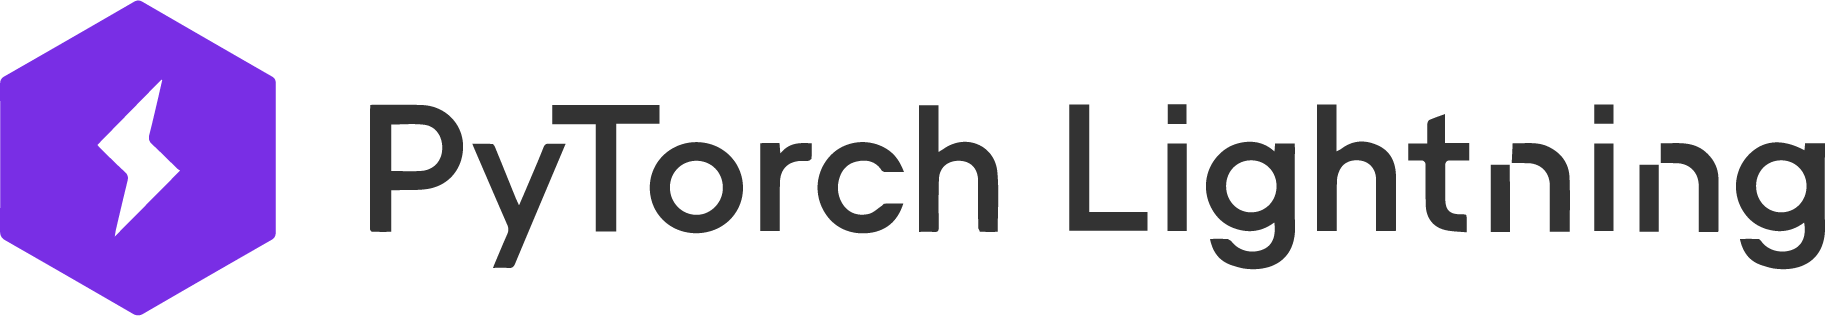{height="60px" width="240px"}](https://pytorchlightning.ai)